In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

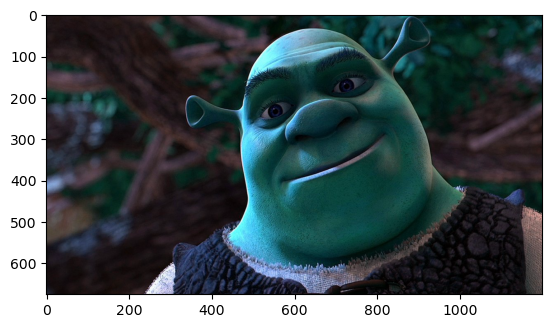

In [2]:
image = cv2.imread('./image.png')
plt.imshow(image);

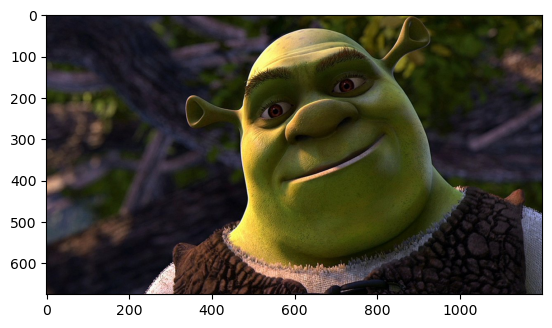

In [3]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

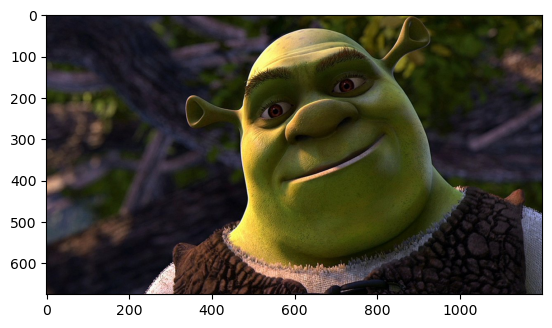

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

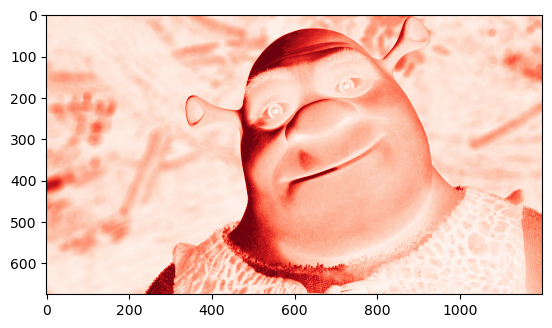

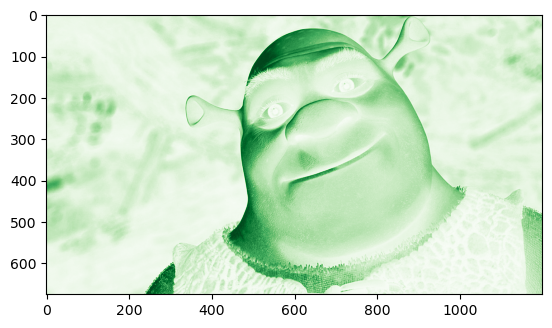

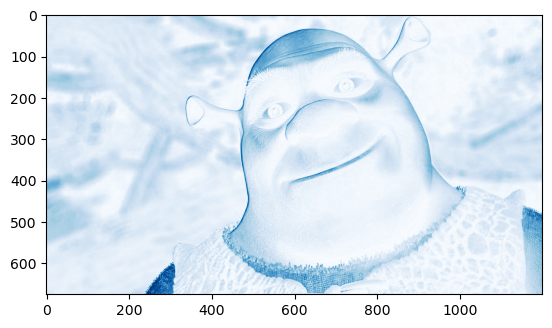

In [5]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)
![alt text](conv.png "")

In [6]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

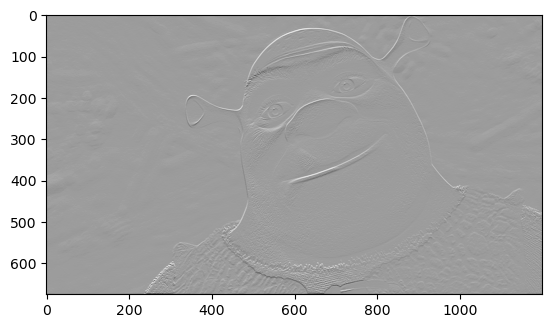

In [7]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

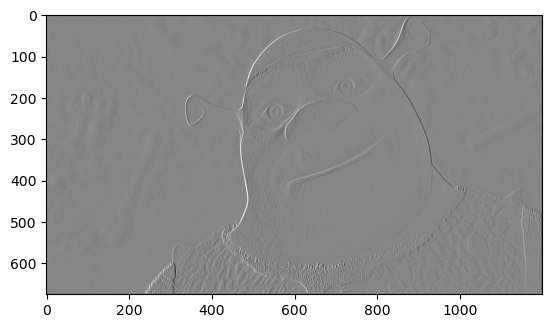

In [8]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

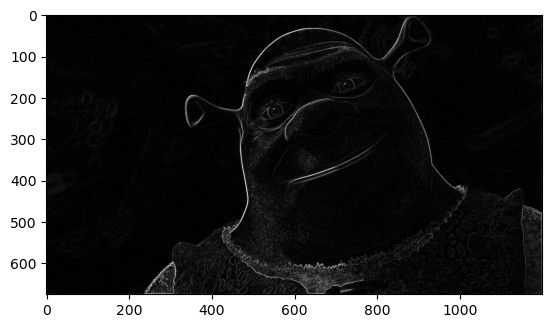

In [9]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [10]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

![alt text](pool.png "")

In [11]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):
    
    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [12]:
def max_pooling(pools: np.array) -> np.array:
    
    num_pools = pools.shape[0]
    
    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    
    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))
        
    return np.array(pooled).reshape(tgt_shape)

In [13]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [3]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm import tqdm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

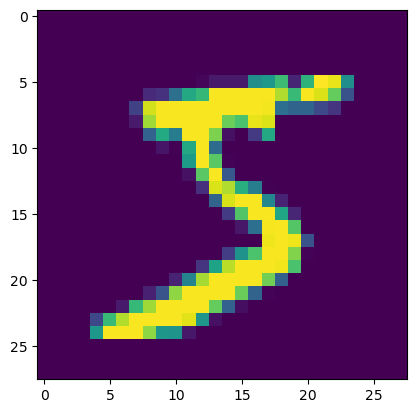

In [6]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [18]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [19]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(test_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        
            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [20]:
train(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 93.86it/s]


Epoch: 0, loss: 0.32069042325019836, accuracy: 0.9103


100%|██████████| 157/157 [00:01<00:00, 86.99it/s]


Epoch: 2, loss: 0.22987008094787598, accuracy: 0.9366


100%|██████████| 157/157 [00:01<00:00, 95.83it/s]

Epoch: 4, loss: 0.18213164806365967, accuracy: 0.9462


In [21]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон 
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [22]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 67.38it/s]


Epoch: 0, loss: 0.1804814487695694, accuracy: 0.9469


100%|██████████| 157/157 [00:02<00:00, 72.62it/s]


Epoch: 2, loss: 0.09493010491132736, accuracy: 0.9724


100%|██████████| 157/157 [00:02<00:00, 71.39it/s]

Epoch: 4, loss: 0.07915205508470535, accuracy: 0.9745


# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9746`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [38]:
from IPython.core.display_functions import clear_output


def train2(net, optimizer, train_loader, test_loader,
                             epochs, criterion,
                             plot=True, verbose=True,
                            ):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            num_of_correct_pred = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(num_of_correct_pred / len(train_loader.dataset))

            losses = []
            num_of_correct_pred = 0
            for data, target in test_loader:
                net_out = net(data)

                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(num_of_correct_pred / len(test_loader.dataset))

            clear_output(wait=True)

            if verbose: # детализация выводимой информации
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {np.round(train_loss_epochs[-1], 3)}/{np.round(test_loss_epochs[-1], 3)} '
                      f'| Accuracy: {np.round(train_accuracy_epochs[-1], 3)}/{np.round(test_accuracy_epochs[-1], 3)}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(test_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt as KI:
        print(KI)

In [32]:
image_size = 28
channels = 1
class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_1, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [33]:
model = ConvClassifier_1(image_size=28)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Network: <ConvClassifier_1>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.065/0.059 | Accuracy: 0.981/0.981


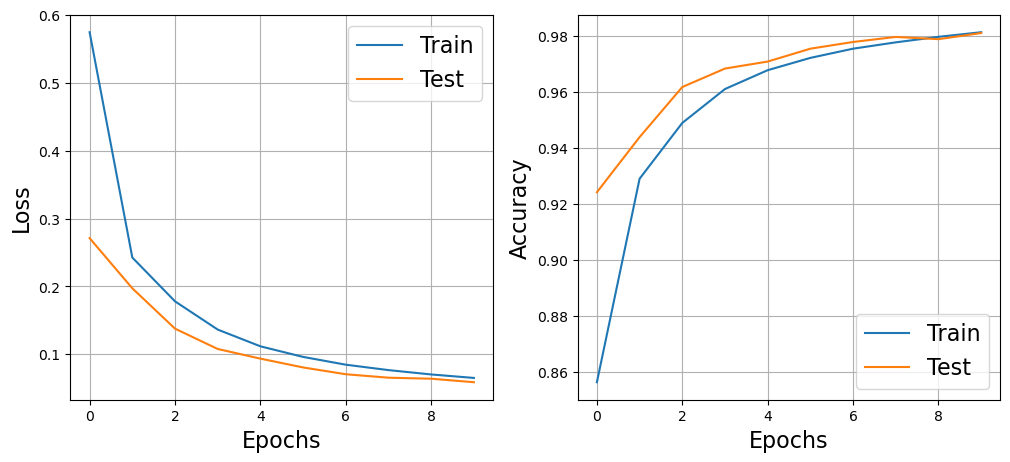

100%|██████████| 10/10 [03:28<00:00, 20.88s/it]


In [34]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
                         train_loader=train_dataloader, test_loader=test_dataloader,
                         plot=True, verbose=True)

In [35]:
image_size = 28
channels = 1
class ConvClassifier_2(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 32, 10),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [36]:
model = ConvClassifier_2(image_size=28)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Network: <ConvClassifier_2>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.035/0.037 | Accuracy: 0.989/0.988


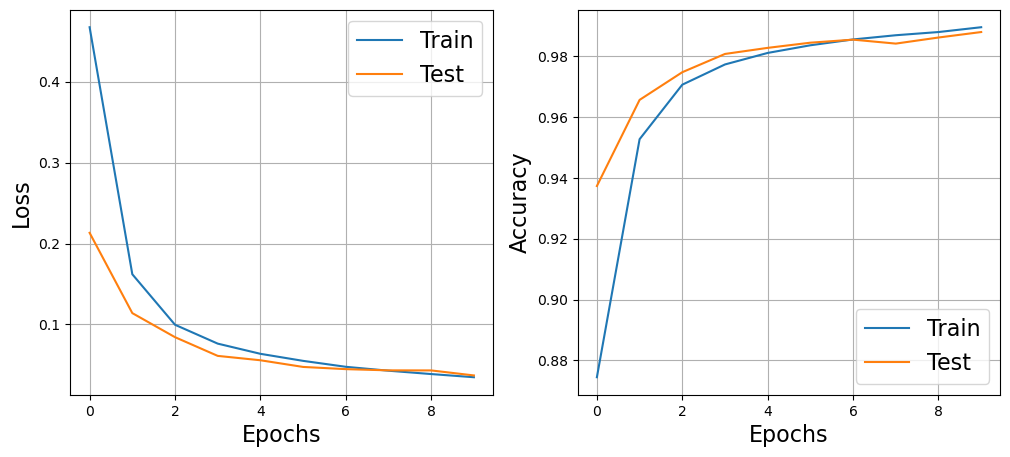

100%|██████████| 10/10 [06:51<00:00, 41.13s/it]


In [37]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
                         train_loader=train_dataloader, test_loader=test_dataloader,
                         plot=True, verbose=True)

In [50]:
class ConvClassifier_3(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 5, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, padding=1),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(3200, 10),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [51]:
model = ConvClassifier_3(image_size=28)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Network: <ConvClassifier_3>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.028/0.031 | Accuracy: 0.992/0.989


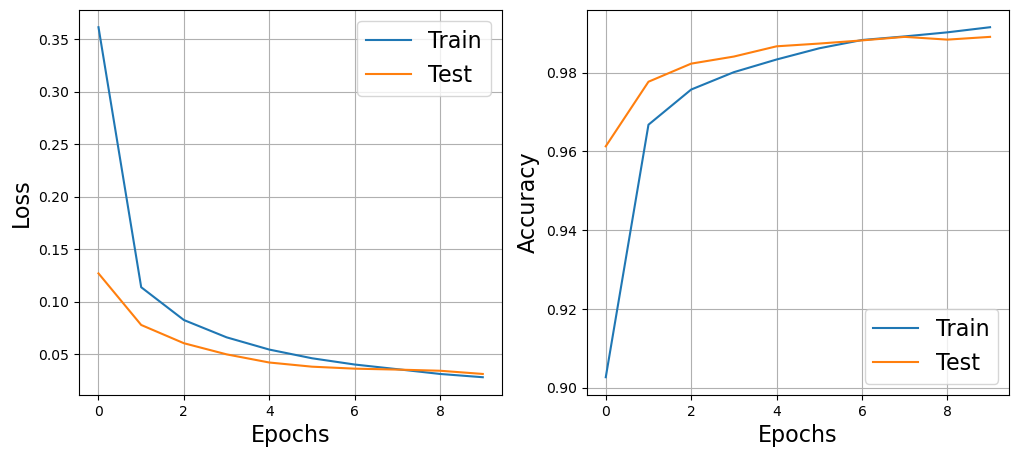

100%|██████████| 10/10 [05:33<00:00, 33.36s/it]


In [52]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
                         train_loader=train_dataloader, test_loader=test_dataloader,
                         plot=True, verbose=True)

Видно, что добавление новой прослойки nn.Conv2d в пайплайн улучшает качество модели. При этом увелечение количества ядер в nn.Conv2d также улучшает качество модели. Также поигрался с другими параметрами, пока составлял результирующие графики, представлены лушие конфигурации, которые удалось подобрать


Видно, что бейзлайн был улучшен в разы с помощью этого.
